In [1]:
import sys 
path_project = '/home/danshach/pot_store/beegfs_scratch/Xalantir'
sys.path.insert(1, path_project)
from base import utilities, data_augmentation, detector, experiment_dataloader, simulation_dataloader, real_dataloader, setup
import random
import math
from skimage import filters, morphology, util

What I want this evaluation file to do?
1) get a representitive subset of simulations and experiments
2) plot the steps of the fitting for both simulations and experiments
3) plots figures in array and single

In [ ]:
def get_training_scope():
    intervals = {
        'radius':
                {'all': {'start': 0.5, 'stop': 7.6, 'step': 0.1}, 'low': {'start': 0.5, 'stop': 4.6, 'step': 0.1}, 'medium': {'start': 1.5, 'stop': 5.6, 'step': 0.1},
                 'high': {'start': 2.5, 'stop': 7.6, 'step': 0.1}, 'stepsize': {'start': 1.0, 'stop': 8.0, 'step': 1.0}, 'costume':{'start': 1.2, 'stop': 7.6, 'step': 0.1},
                 'test':{'start': 2.5, 'stop': 5.1, 'step': 0.1}},
        'distance':
                {'all': {'start': 0.5, 'stop': 7.6, 'step': 0.1}, 'low': {'start': 0.5, 'stop': 4.6, 'step': 0.1}, 'medium': {'start': 1.5, 'stop': 5.6, 'step': 0.1},
                 'high': {'start': 2.5, 'stop': 7.6, 'step': 0.1}, 'stepsize': {'start': 3.0, 'stop': 16.0, 'step': 1.0}, 'costume':{'start': 3.8, 'stop': 15.1, 'step': 0.1},
                 'test':{'start': 10.0, 'stop': 10.2, 'step': 0.1}},
        'sigma_radius':
                {'all': {'start': 0.1, 'stop': 0.51, 'step': 0.01}, 'low': {'start': 0.1, 'stop': 0.25, 'step': 0.01}, 'medium': {'start': 0.18, 'stop': 0.33, 'step': 0.01},
                 'high': {'start': 0.33, 'stop': 0.51, 'step': 0.01}, 'stepsize': {'start': 0.1, 'stop': 0.51, 'step': 0.1}, 'costume': {'start': 0.30, 'stop': 0.31, 'step': 0.01},
                 'test':{'start': 0.3, 'stop': 0.31, 'step': 0.01}},
        'omega_distance':
                {'all': {'start': 0.1, 'stop': 0.51, 'step': 0.01}, 'low': {'start': 0.1, 'stop': 0.25, 'step': 0.01}, 'medium': {'start': 0.18, 'stop': 0.33, 'step': 0.01},
                 'high': {'start': 0.33, 'stop': 0.51, 'step': 0.01}, 'stepsize': {'start': 0.1, 'stop': 0.51, 'step': 0.1}, 'costume': {'start': 0.19, 'stop': 0.27, 'step': 0.01},
                 'test':{'start': 0.2, 'stop': 0.21, 'step': 0.01}}
                 }
    chosen_intervals ={
            'radius': intervals['radius']['stepsize'],
            'distance':  intervals['distance']['stepsize'],
            'sigma_radius': intervals['sigma_radius']['test'],
            'omega_distance':  intervals['omega_distance']['test']}
    return chosen_intervals

def initialize_experiment(path_project, arg):
    detec = detector.Pilatus1M(mask=(path_project + 'base/masks/' + arg.maskfile))
    experiment_setup = setup.Experiment(
        path_project=path_project,
        experiment_parameter={
            'materials': arg.materials,
            'wavelength': arg.wavelength,
            'incidence_angle': arg.incidence_angle,
            'direct_beam_position': (arg.db_y, arg.db_x),
            'sample_detector_distance': arg.distance
        },
        detector=detec,
        experiment_maskfile=arg.experiment_maskfile
    )
    return experiment_setup, detec

def load_simulation_data(simulation_dataloader, path_simulation_data, arg):
    simulation = simulation_dataloader.Simulation(path=path_simulation_data, samples=arg.samples)
    if True:
        return simulation.load_extended_data()
    else:
        return simulation.load_data()

def fit_simulation(simulation, da):
    n1, n2, two_theta_f_min, two_theta_f_max, alpha_f_min, alpha_f_max = simulation.get_grid_parameter(key='1')
    two_theta_f, alpha_f, q_y, q_z = da.convert_from_cartesian_to_reciprocal_space()
    two_theta_f_crop_index = int(round((two_theta_f.max() / (two_theta_f_max - two_theta_f_min)) * n2))
    alpha_f_crop_index = int(round((alpha_f.max() / (alpha_f_max - alpha_f_min)) * (n1 - 1)))
    return two_theta_f_crop_index, alpha_f_crop_index

def process_image(image, da, detector_mask, shape_to_bin, two_theta_f_crop_index, alpha_f_crop_index):
    image = da.crop_simulation(image=image, y=alpha_f_crop_index, x=two_theta_f_crop_index)
    image = da.bin_int(to_bin=image, bin_to_shape=shape_to_bin)
    image = util.random_noise(image=image, mode='poisson')
    image = da.crop_window(image)
    image = da.mask_image(image=image, mask=detector_mask)
    image = da.crop_modules(image=image)
    image = da.normalize(image=image)
    grayscale = util.img_as_ubyte(image)
    threshold = filters.threshold_otsu(grayscale)
    grayscale[grayscale >= threshold] = 255
    grayscale[grayscale < threshold] = 0
    return grayscale

def apply_smoothing(grayscale, smooth_values, index):
    for s in smooth_values:
        median = filters.rank.median(grayscale, morphology.disk(s))
        gradient = filters.rank.gradient(median, morphology.disk(1))
        watershed = segmentation.watershed(gradient, watershed_line=True)
        yield s, median, gradient, watershed

def save_plots(image, index, stage, path, z_limits=None, mode='log'):
    utilities.draw_plot(image, f"{index}_{stage}", z_limits=z_limits, save=True, path=path, mode=mode)

def data_augmentation_simulation():
    path_simulation_data = {
        'path': path_project + '/data/simulation/',
        'files': ['database_1.h5', 'database_2.h5']
    }
    path_experiment_data = {
        'path': '/home/danshach/pot_store/beegfs_scratch/simple_net/experiment/sputter/',
        'folders': ['sputter_100K', 'sputter_300K', 'sputter_400K', 'sputter_500K'],
        'target_value_files': ['tar_100K.csv', 'tar_300K.csv', 'tar_400K.csv', 'tar_500K.csv']
    }
    arg = arguments.parse()
    experiment_setup, detector = initialize_experiment(path_project, arg)
    da = data_augmentation.DataAugmentation(experiment_setup=experiment_setup, detector=detec)
    
    # Load simulation data
    images, target_values = load_simulation_data(simulation_dataloader, path_simulation_data, arg)

    # Simulation fitting and masking
    two_theta_f_crop_index, alpha_f_crop_index = fit_simulation(simulation, da)
    detector_mask = da.crop_detector_mask()
    experiment_mask = da.crop_experiment_mask()
    shape_to_bin = (int(math.ceil(0.5 * detector_mask.shape[0])), int(math.ceil(0.5 * detector_mask.shape[1])))
    detector_mask = da.crop_window(da.bin_mask(detector_mask, bin_to_shape=shape_to_bin))
    experiment_mask = da.bin_mask(experiment_mask, bin_to_shape=shape_to_bin)
    
    # Set z-limits
    z_limits_range = [1e-5, 10000]

    # Image processing loop
    for i in range(20):
        index = random.randint(0, len(images) - 1)
        image = images[index]

        save_plots(image, index, '0_Raw', '/path/to/save/', z_limits=[0, image.max()])
        
        grayscale = process_image(image, da, detector_mask, shape_to_bin, two_theta_f_crop_index, alpha_f_crop_index)
        save_plots(grayscale, index, '7_Graustufe', '/path/to/save/')
        
        smooth_values = [0, 1, 3, 5]
        for s, median, gradient, watershed in apply_smoothing(grayscale, smooth_values, index):
            save_plots(median, index, f'7_Median_SF{s}', '/path/to/save/', z_limits=[0, median.max()])
            save_plots(gradient, index, f'8_Gradient_SF{s}', '/path/to/save/', z_limits=[0, gradient.max()])
            save_plots(watershed, index, f'9_Watershed_SF{s}', '/path/to/save/', z_limits=[0, watershed.max()])
            utilities.draw_plot_grayscale(watershed, title=f"{index}_9_Watershed_Graustufe_SF{s}", save=True, path='/path/to/save/')


In [3]:
import seaborn as sns

In [4]:
from matplotlib import pyplot as plt
def visualize_data(dataset):
    # Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface
    # for drawing attractive and informative statistical graphics.
    sns.pairplot(dataset[['distance', 'omega_distance', 'radius', 'sigma_radius']], diag_kind='kde')
    plt.show()

In [8]:
data

{'distance': array([ 6.2,  7.3,  8.1,  9.5, 13.3]),
 'omega_distance': array([0.15, 0.18, 0.2 , 0.24, 0.24]),
 'radius': array([1.5, 3.1, 3.1, 4.2, 4.8]),
 'sigma_radius': array([0.14, 0.15, 0.19, 0.26, 0.27])}

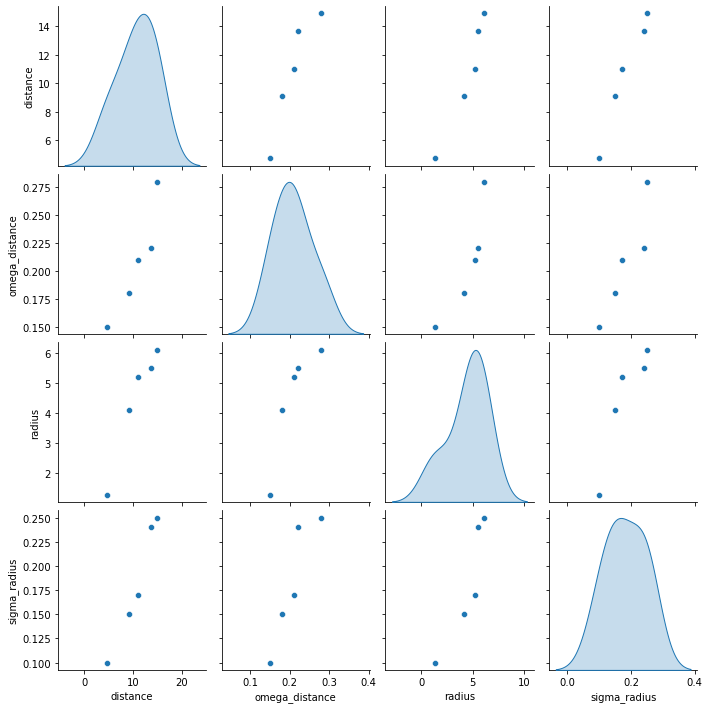

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
data = {
    'distance': np.sort(np.round(np.random.uniform(3.8,15.0,5),1)),
    'omega_distance': np.sort(np.round(np.random.uniform(0.1,0.3,5),2)),
    'radius': np.sort(np.round(np.random.uniform(1.2,7.0,5),1)),
    'sigma_radius': np.sort(np.round(np.random.uniform(0.1,0.3,5),2))    
}
df = pd.DataFrame(data)
visualize_data(df)

In [9]:
pip install --upgrade seaborn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 1.2 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
